## 0. Goal
Run UMAP on the trained VAE latent features <br>
Differ from v1: Use VAE trained on duration-proportional dataset

In [1]:
import os, sys, importlib, librosa, glob, h5py, tqdm, pickle
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed
import random
import umap, hdbscan
from collections import Counter
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
import torch
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

plt.rcParams['pdf.fonttype'] = 42 

In [2]:
# import my utility script
cluster_script_path = '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/'
sys.path.insert(1, cluster_script_path)
import vae_goffinet, hopkins
importlib.reload(vae_goffinet)

<module 'vae_goffinet' from '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/vae_goffinet.py'>

In [3]:
# create a custom colormap for spectrogram
jet = plt.get_cmap('jet', 255)
# Extract jet colors and prepend black at the beginning
jet_colors = jet(np.linspace(0, 1, 255))
custom_colors = np.vstack([[0, 0, 0, 1], jet_colors])  # Black for 0, then jet
custom_cmap = ListedColormap(custom_colors)

## 1. Inputs

In [4]:
fd_z4 = '/mnt/z4'
fd_data = os.path.join(fd_z4, 'zz367', 'EphysMONAO', 'Analyzed', 'vaeWav')
birdIDs = ['pair5RigCCU29', 'pair4RigACU68', 'pair4RigBCU53', 'pair2RigBCU25']
# color limits when calculating spectrograms, depending on the audio amplitude, may differ between birds
clims = [[1.5,7], [1.5,7], [1.5,8.5], [1.5,8]]
# what syllable to analyze, empty means all syllable with annotation
syl = ['v', 'b', 'h', 'e', 'x']
# what spectroram dataset to use, see ZZp1_makeSpec_traj_v1.ipynb
spec_suffix = 'Spectrogram2'
spec_run = 'spec_goffinet_traj_256_236'
# what chopped dataset to use
chop_suffix = 'Chop3'
chop_run = 'traj_chop_32_1_32'
# what VAE run to use
vae_suffix = 'VAE3'
vae_run = chop_run
# shape of the spectrogram window
X_SHAPE = (128, 128)

In [6]:
# parameters for UMAP
param_umap = {'n_components':2, 'n_neighbors':25, 'min_dist':0, 'metric':'euclidean'}
# where to save UMAP results
umap_suffix = 'UMAP3'
umap_run = f'{param_umap["n_components"]}_{param_umap["n_neighbors"]}_{param_umap["min_dist"]}_{param_umap["metric"]}'
print(umap_run)

2_25_0_euclidean


## 2. Run UMAP on all or selected syllable categories

In [7]:
bi = 0
bd = birdIDs[bi]
fd_save = os.path.join(fd_data, bd, 'Traj', umap_suffix, umap_run)
if not os.path.exists(fd_save):
    os.makedirs(fd_save)
print(fd_save)

/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5RigCCU29/Traj/UMAP3/2_25_0_euclidean


In [8]:
# load the latent features
fd_vae = os.path.join(fd_data, bd, 'Traj', vae_suffix, vae_run)
fn_latent_m = os.path.join(fd_vae, 'latentM.csv')
latent_m = np.loadtxt(fn_latent_m, delimiter=',')
print(latent_m.shape)

(343424, 32)


In [9]:
# also get the meta info about the sliding windows
fd_chop = os.path.join(fd_data, bd, 'Traj', chop_suffix)
fn_info = os.path.join(fd_chop, f'{bd}.{chop_run}.chop.info.csv')
info = pd.read_csv(fn_info, index_col=0)
print(info.shape)
info.head()

(343424, 16)


ri  i_i  i_s  i_e                                             fn_wav  \
0  74378    0   79  111  /mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5...   
1  74378    1  213  245  /mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5...   
2  74378    2  113  145  /mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5...   
3  74378    3  124  156  /mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5...   
4  74378    4  235  267  /mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5...   

   s_idx  istart    iend label  \
0     29  238240  241439     v   
1     29  238240  241439     v   
2     29  238240  241439     v   
3     29  238240  241439     v   
4     29  238240  241439     v   

                                              spec_f  \
0  [ 250.          307.08661417  364.17322835  42...   
1  [ 250.          307.08661417  364.17322835  42...   
2  [ 250.          307.08661417  364.17322835  42...   
3  [ 250.          307.08661417  364.17322835  42...   
4  [ 250.          307.08661417  364.17322835  42...   

                                              spec_t  i_start   i_end  \
0  [0.    0.001 0.002 0.003 0.004 0.005 0.006 0.0...   236640  243039   
1  [0.    0.001 0.002 0.003 0.004 0.005 0.006 0.0...   236640  243039   
2  [0.    0.001 0.002 0.003 0.004 0.005 0.006 0.0...   236640  243039   
3  [0.    0.001 0.002 0.003 0.004 0.005 0.006 0.0...   236640  243039   
4  [0.    0.001 0.002 0.003 0.004 0.005 0.006 0.0...   236640  243039   

   zero_start  zero_end  rel_ori  
0           0         0     1600  
1           0         0     1600  
2           0         0     1600  
3           0         0     1600  
4           0         0     1600

In [24]:
Counter(info['label'])

Counter({'x': 114692, 'v': 108083, 'b': 81995, 'h': 27623, 'e': 11031})

In [10]:
umap_syl = ['v', 'b', 'h', 'e', 'x']
# umap_syl = ['v']
# umap_syl = ['v', 'b']
# umap_syl = ['v', 'b', 'x']
syl_str = ''.join(umap_syl)

# select rows that belong to the syllable
idx_syl = np.array(info[info['label'].isin(umap_syl)].index)
info_this = info.iloc[idx_syl,:].copy()
info_this.index = range(info_this.shape[0])
latent_this = latent_m[idx_syl,:].copy()
print(info_this.shape, latent_this.shape)

(343424, 16) (343424, 32)


In [ ]:
# run UMAP
# add latent_m to the embedding data frame
embed = info_this.copy()
for ii in range(latent_this.shape[1]):
    embed[f'vae{ii}'] = latent_this[:,ii]
    
print(param_umap)
umap_model = umap.UMAP(n_neighbors=param_umap['n_neighbors'], n_components=param_umap['n_components'], min_dist=param_umap['min_dist'], 
                                              metric=param_umap['metric'], random_state=1118, verbose=True)
res = umap_model.fit_transform(latent_this)

# add UMAP embedding to the dataframe
for jj in range(res.shape[1]):
    embed[f'umap{jj+1}'] = res[:,jj]

{'n_components': 2, 'n_neighbors': 25, 'min_dist': 0, 'metric': 'euclidean'}
UMAP(min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Mon Jul 28 19:49:35 2025 Construct fuzzy simplicial set
Mon Jul 28 19:49:36 2025 Finding Nearest Neighbors
Mon Jul 28 19:49:36 2025 Building RP forest with 34 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Mon Jul 28 19:49:42 2025 NN descent for 18 iterations
	 1  /  18
	 2  /  18
	 3  /  18
	Stopping threshold met -- exiting after 3 iterations
Mon Jul 28 19:50:09 2025 Finished Nearest Neighbor Search
Mon Jul 28 19:50:13 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs


IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


Mon Jul 28 19:53:23 2025 Finished embedding


In [ ]:
# save the UMAP model for later usage
fn_umap = os.path.join(fd_save, f'UMAPmodel_{bd}.{syl_str}.p')
pickle.dump(umap_model, open(fn_umap, 'wb'))

Mon Jul 28 19:55:27 2025 Worst tree score: 0.76989960
Mon Jul 28 19:55:27 2025 Mean tree score: 0.77447583
Mon Jul 28 19:55:27 2025 Best tree score: 0.77673081
Mon Jul 28 19:55:29 2025 Forward diversification reduced edges from 8585600 to 2873182
Mon Jul 28 19:55:31 2025 Reverse diversification reduced edges from 2873182 to 2873182
Mon Jul 28 19:55:33 2025 Degree pruning reduced edges from 3233494 to 3233494
Mon Jul 28 19:55:33 2025 Resorting data and graph based on tree order
Mon Jul 28 19:55:33 2025 Building and compiling search function


In [23]:
# save the embedding results
fn_embed = os.path.join(fd_save, f'{bd}.{syl_str}.{vae_run}.embedding.csv')
embed.to_csv(fn_embed)
print(fn_embed)

/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5RigCCU29/Traj/UMAP3/2_25_0_euclidean/pair5RigCCU29.vbhex.traj_chop_32_1_32.embedding.csv


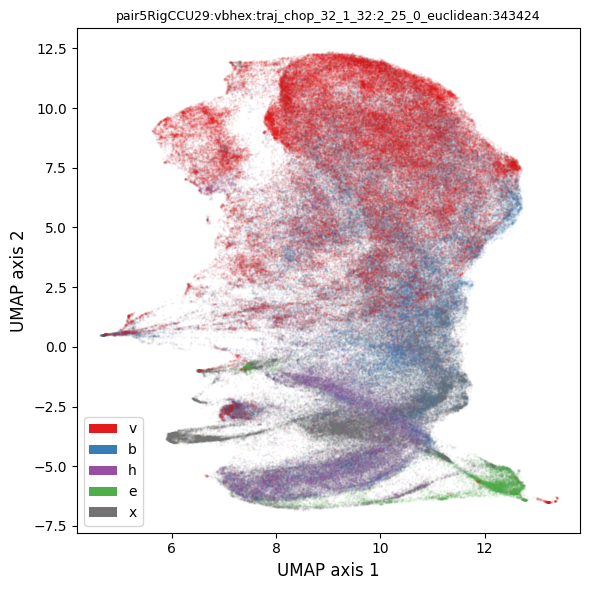

In [40]:
## plot embedding
col_list = ['#e41a1c', '#377eb8', '#984ea3', '#4daf4a', '#737373']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[6, 6])
# for si, ss in enumerate(syl):
# plot the X first
for si in range(len(syl)-1, -1, -1):
    ss = syl[si]
    embed_s = embed[embed['label']==ss]
    ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.075, c=col_list[si], rasterized=True)
# add legend
legends = [Patch(facecolor=col, label=name) for col, name in zip(col_list, syl)]
plt.legend(handles=legends, loc='lower left')
ax.set_title(f'{bd}:{syl_str}:{chop_run}:{umap_run}:{embed.shape[0]}', fontsize=9)
ax.set_xlabel('UMAP axis 1', fontsize=12)
ax.set_ylabel('UMAP axis 2', fontsize=12)
plt.tight_layout()
# save fig
fn_fig =os.path.join(fd_save, f'{bd}.{syl_str}.embedding.pdf')
fig.savefig(fn_fig, dpi=600)

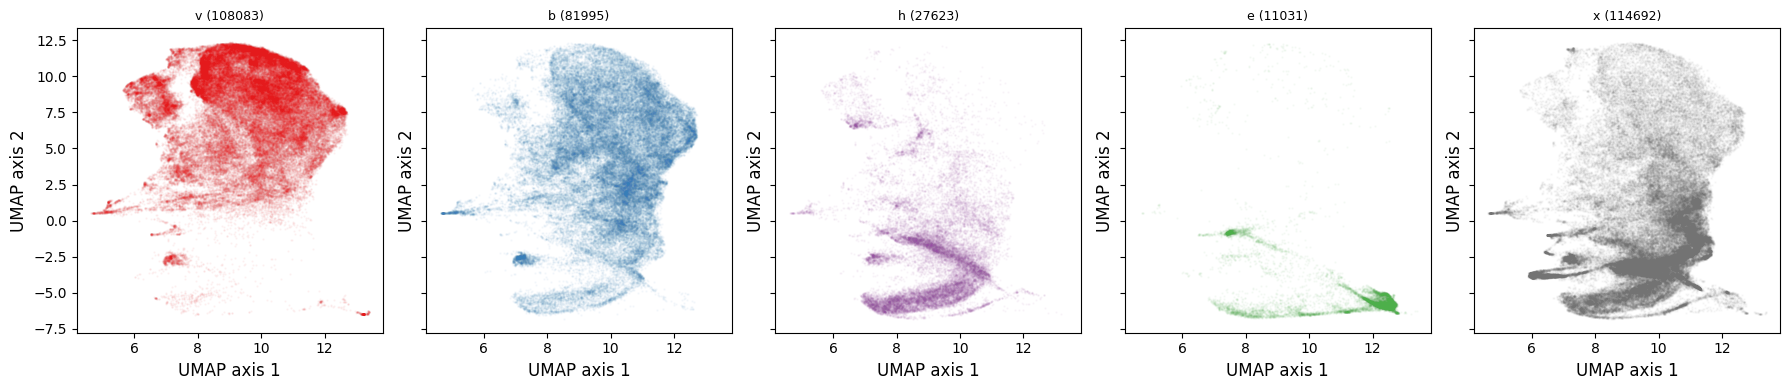

In [38]:
# plot in seperate panels
col_list = ['#e41a1c', '#377eb8', '#984ea3', '#4daf4a', '#737373']
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=[18, 4], sharex=True, sharey=True)
# for si, ss in enumerate(syl):
# plot the X first
for si in range(len(syl)-1, -1, -1):
    ax = axes[si]
    ss = syl[si]
    embed_s = embed[embed['label']==ss]
    ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.05, c=col_list[si], rasterized=True)
    ax.set_title(f'{ss} ({embed_s.shape[0]})', fontsize=9)
    ax.set_xlabel('UMAP axis 1', fontsize=12)
    ax.set_ylabel('UMAP axis 2', fontsize=12)
plt.tight_layout()
# save fig
fn_fig =os.path.join(fd_save, f'{bd}.{syl_str}.embeddingInd.pdf')
fig.savefig(fn_fig, dpi=600)

## 3. Use the intermediate VAE states, check if there is any difference

In [59]:
# save results in a subfolder
fd_save_this = os.path.join(fd_save, 'intermediateEpoch')
if not os.path.exists(fd_save_this):
    os.makedirs(fd_save_this)
print(fd_save_this)
epoch = list(range(10, 51, 10))
epoch

/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5RigCCU29/Traj/UMAP3/2_25_0_euclidean/intermediateEpoch


[10, 20, 30, 40, 50]

In [52]:
fn_spec = os.path.join(fd_chop, f'{bd}.{chop_run}.chop.h5')
train_data = vae_goffinet.SpecDataset(fn_spec)

5366it [00:57, 93.71it/s]


{'n_components': 2, 'n_neighbors': 25, 'min_dist': 0, 'metric': 'euclidean'}
UMAP(min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Mon Jul 28 20:59:26 2025 Construct fuzzy simplicial set
Mon Jul 28 20:59:26 2025 Finding Nearest Neighbors
Mon Jul 28 20:59:26 2025 Building RP forest with 34 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Mon Jul 28 20:59:30 2025 NN descent for 18 iterations
	 1  /  18
	 2  /  18
	 3  /  18
	Stopping threshold met -- exiting after 3 iterations
Mon Jul 28 20:59:51 2025 Finished Nearest Neighbor Search
Mon Jul 28 20:59:53 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Jul 28 21:03:02 2025 Finished embedding


5366it [00:56, 94.76it/s]


{'n_components': 2, 'n_neighbors': 25, 'min_dist': 0, 'metric': 'euclidean'}
UMAP(min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Mon Jul 28 21:04:12 2025 Construct fuzzy simplicial set
Mon Jul 28 21:04:12 2025 Finding Nearest Neighbors
Mon Jul 28 21:04:12 2025 Building RP forest with 34 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Mon Jul 28 21:04:16 2025 NN descent for 18 iterations
	 1  /  18
	 2  /  18
	 3  /  18
	Stopping threshold met -- exiting after 3 iterations
Mon Jul 28 21:04:36 2025 Finished Nearest Neighbor Search
Mon Jul 28 21:04:38 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Jul 28 21:07:48 2025 Finished embedding


5366it [00:56, 95.71it/s] 


{'n_components': 2, 'n_neighbors': 25, 'min_dist': 0, 'metric': 'euclidean'}
UMAP(min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Mon Jul 28 21:08:56 2025 Construct fuzzy simplicial set
Mon Jul 28 21:08:56 2025 Finding Nearest Neighbors
Mon Jul 28 21:08:56 2025 Building RP forest with 34 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Mon Jul 28 21:09:01 2025 NN descent for 18 iterations
	 1  /  18
	 2  /  18
	 3  /  18
	Stopping threshold met -- exiting after 3 iterations
Mon Jul 28 21:09:21 2025 Finished Nearest Neighbor Search
Mon Jul 28 21:09:23 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Jul 28 21:12:39 2025 Finished embedding


5366it [00:56, 95.38it/s] 


{'n_components': 2, 'n_neighbors': 25, 'min_dist': 0, 'metric': 'euclidean'}
UMAP(min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Mon Jul 28 21:13:49 2025 Construct fuzzy simplicial set
Mon Jul 28 21:13:49 2025 Finding Nearest Neighbors
Mon Jul 28 21:13:49 2025 Building RP forest with 34 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Mon Jul 28 21:13:53 2025 NN descent for 18 iterations
	 1  /  18
	 2  /  18
	 3  /  18
	Stopping threshold met -- exiting after 3 iterations
Mon Jul 28 21:14:13 2025 Finished Nearest Neighbor Search
Mon Jul 28 21:14:15 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Jul 28 21:17:21 2025 Finished embedding


5366it [00:56, 94.81it/s] 


{'n_components': 2, 'n_neighbors': 25, 'min_dist': 0, 'metric': 'euclidean'}
UMAP(min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Mon Jul 28 21:18:29 2025 Construct fuzzy simplicial set
Mon Jul 28 21:18:29 2025 Finding Nearest Neighbors
Mon Jul 28 21:18:29 2025 Building RP forest with 34 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Mon Jul 28 21:18:34 2025 NN descent for 18 iterations
	 1  /  18
	 2  /  18
	 3  /  18
	Stopping threshold met -- exiting after 3 iterations
Mon Jul 28 21:18:53 2025 Finished Nearest Neighbor Search
Mon Jul 28 21:18:55 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Jul 28 21:22:09 2025 Finished embedding


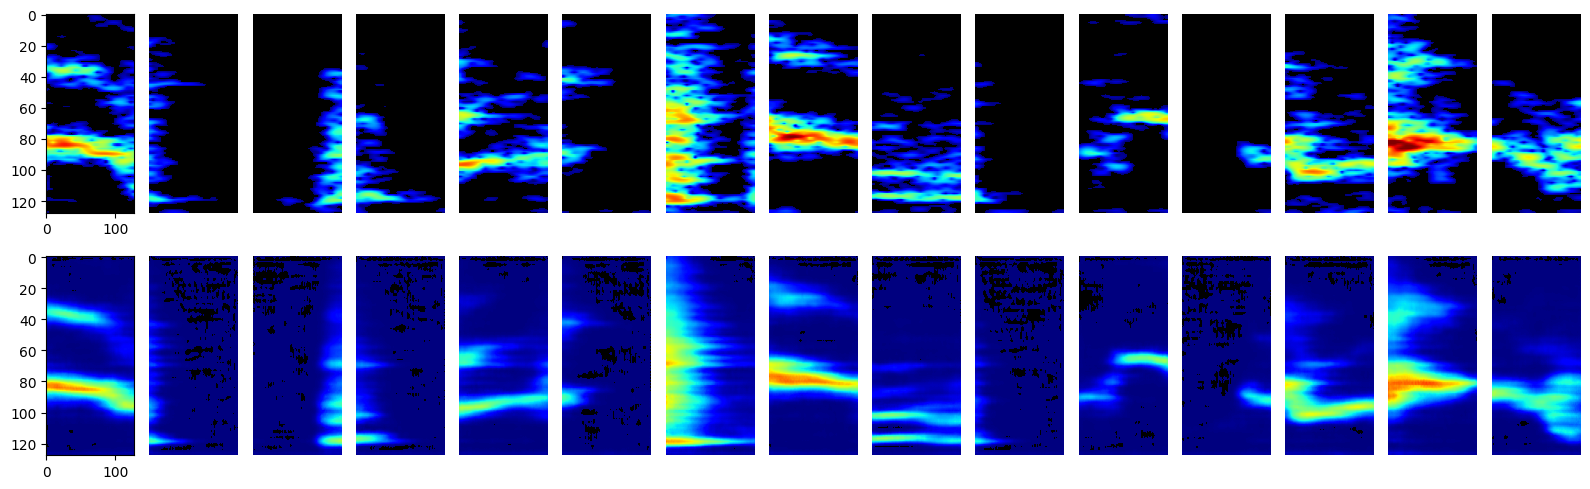

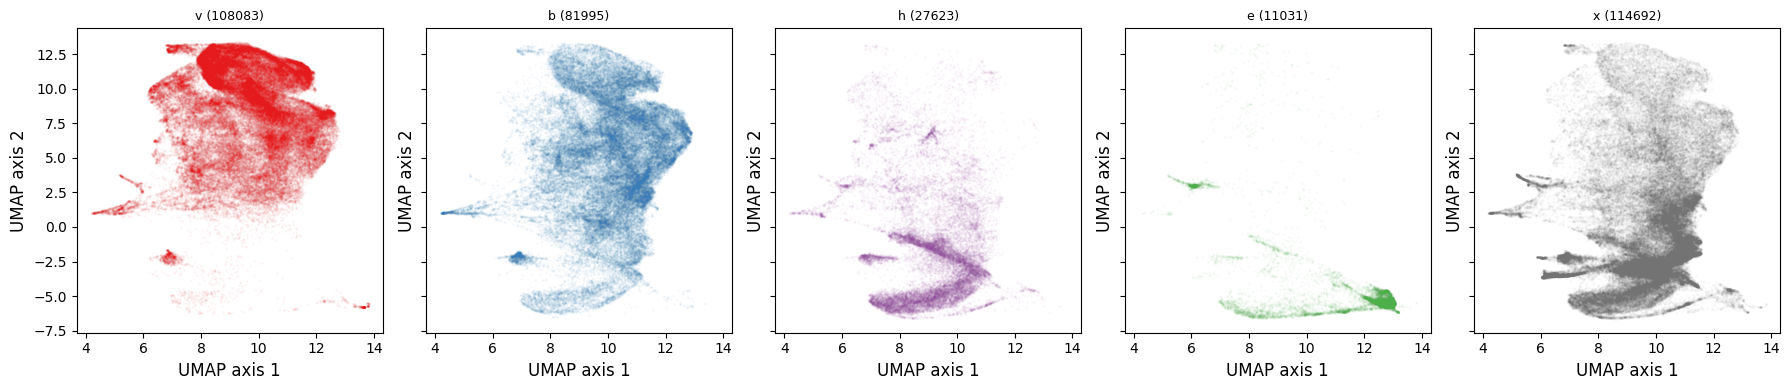

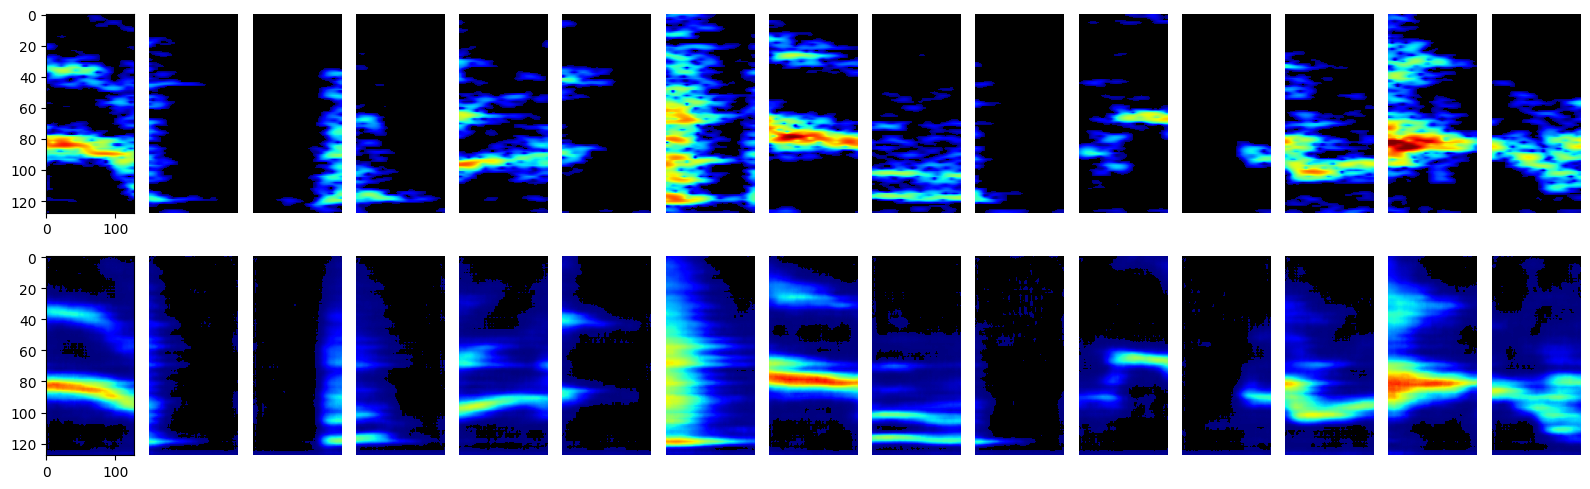

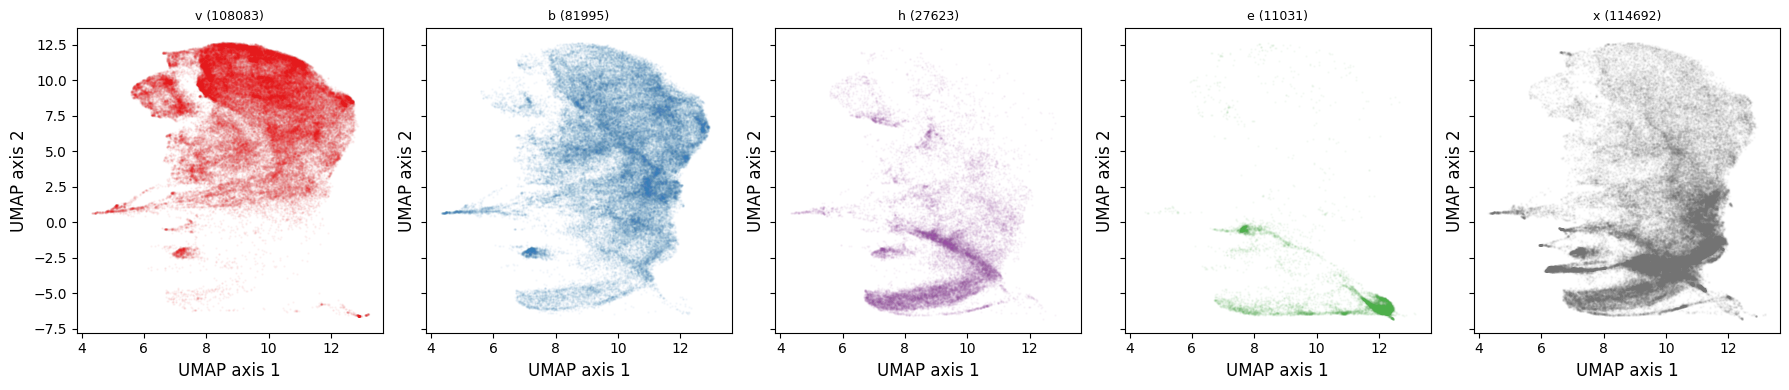

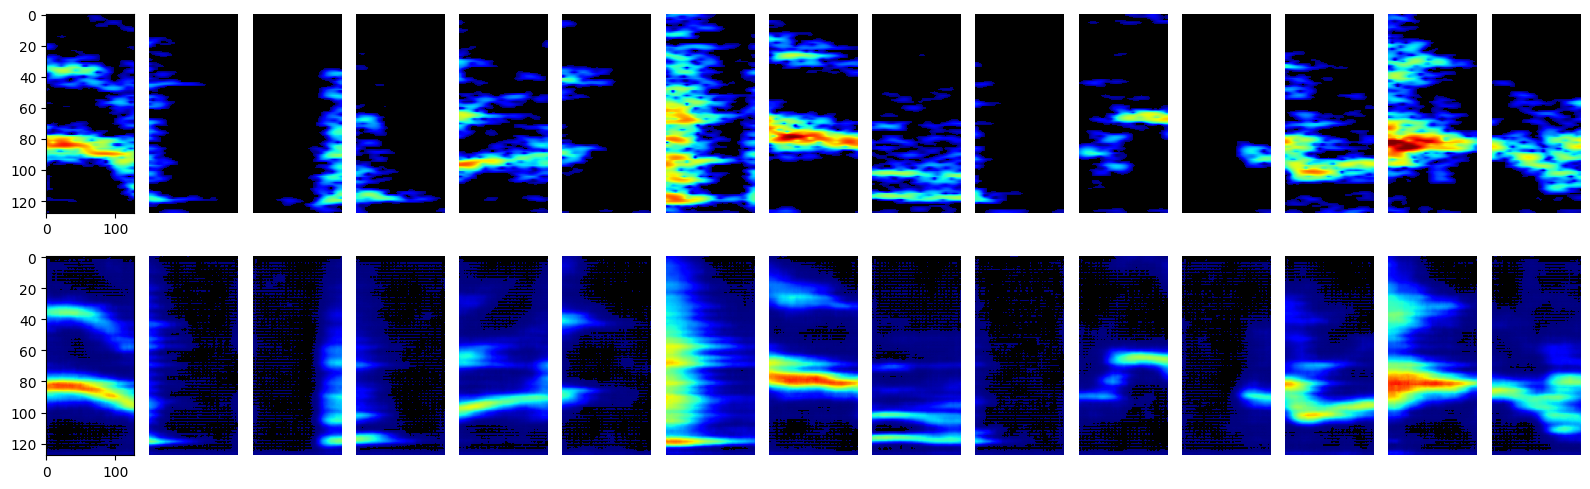

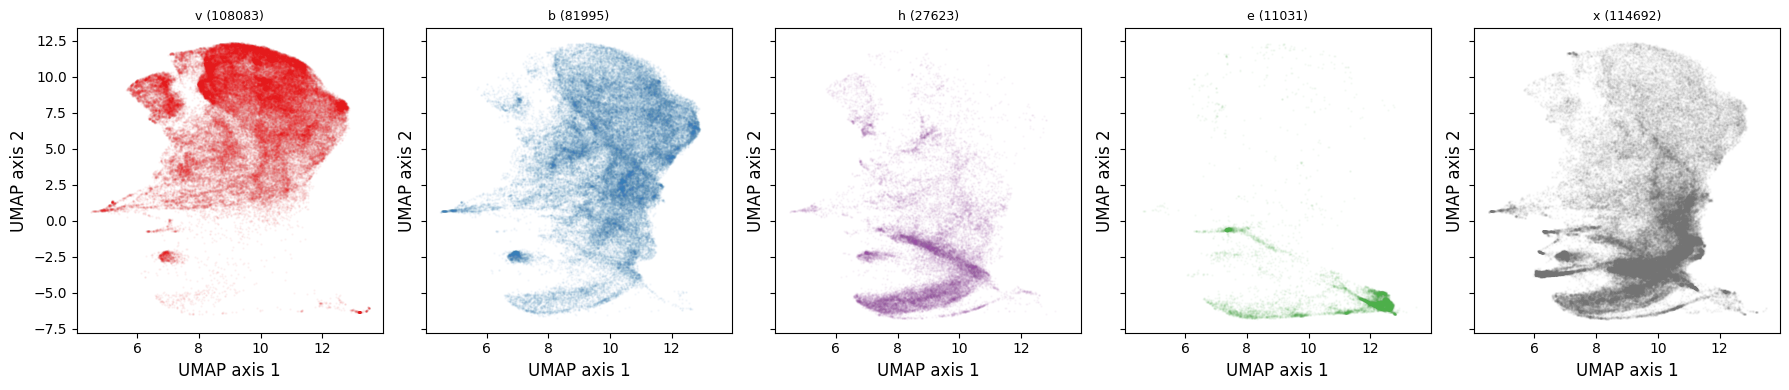

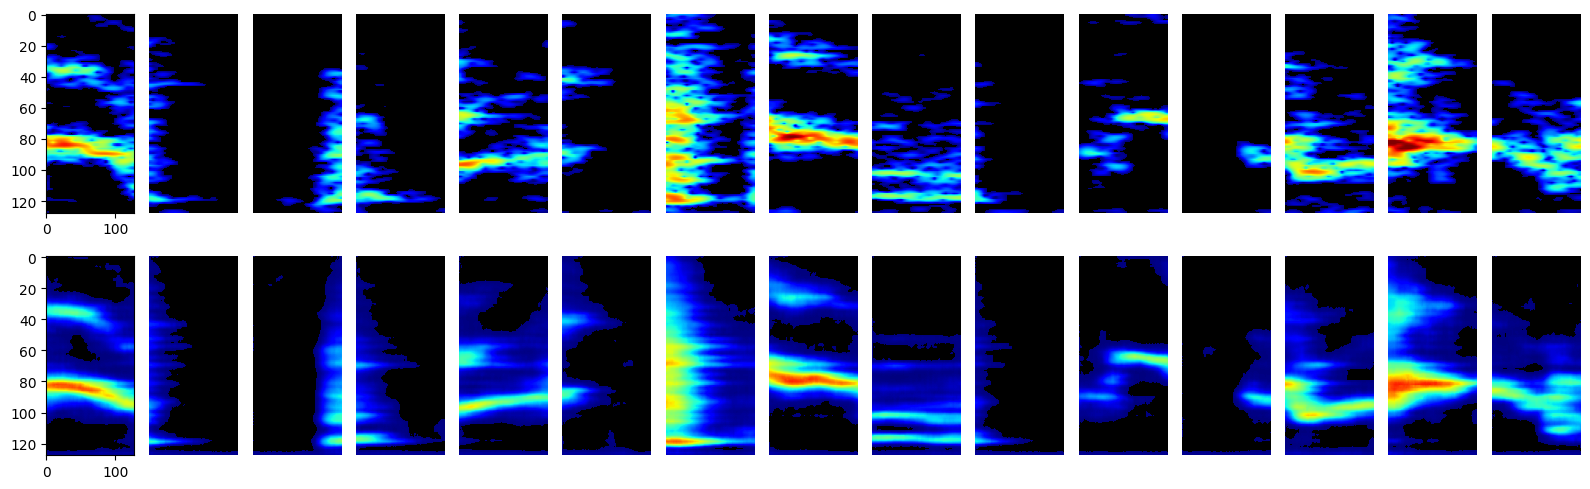

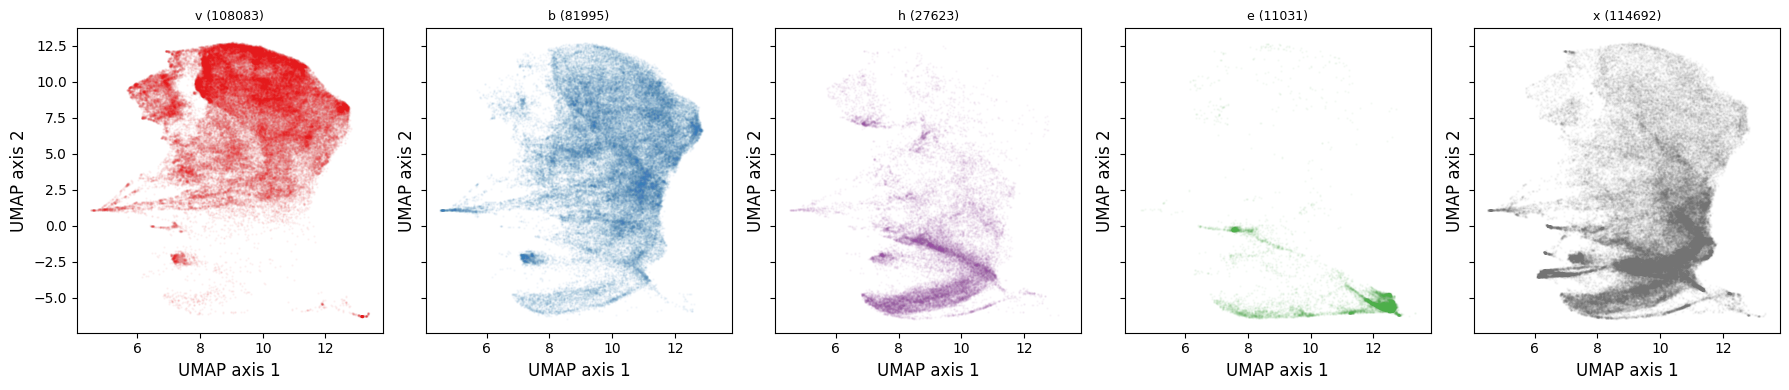

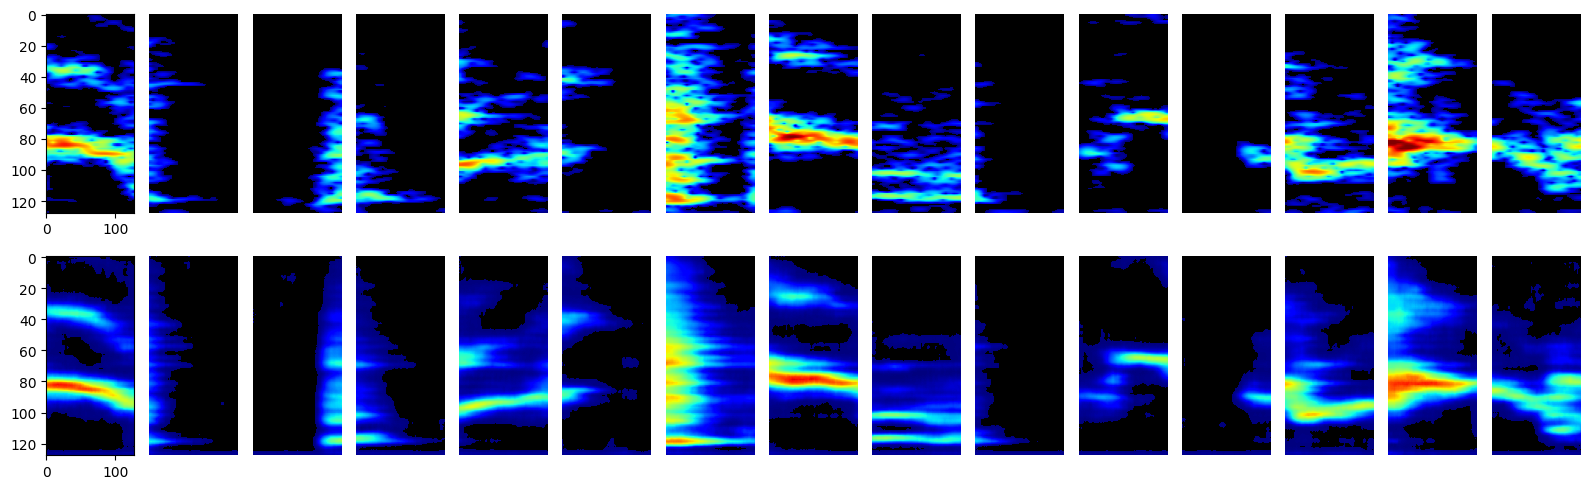

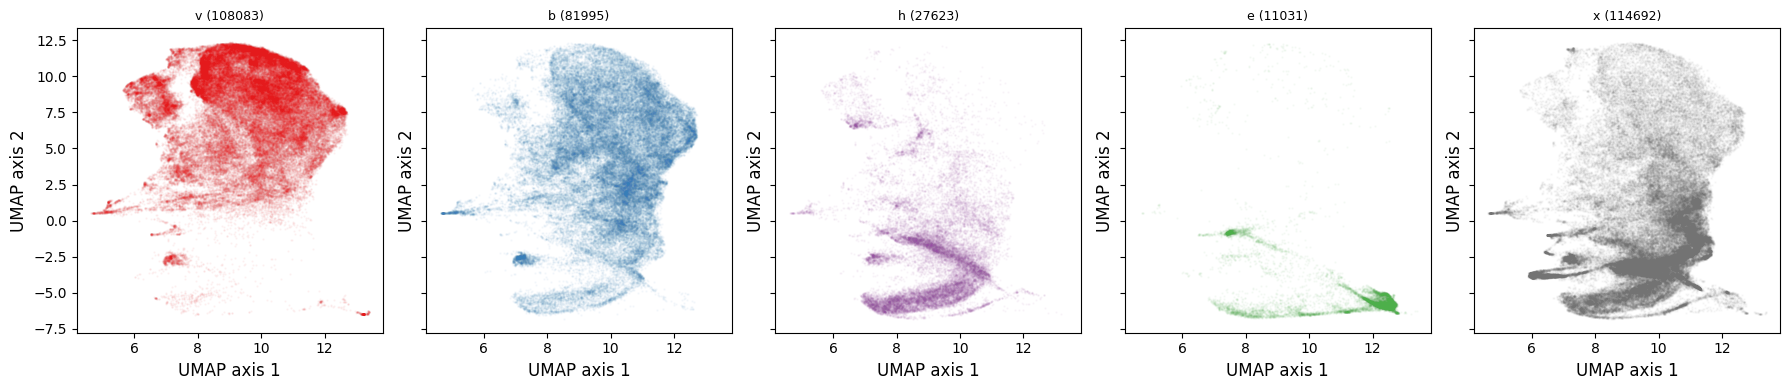

In [68]:
for ep in epoch:
    # ep = epoch[0]
    # init VAE model then load state
    model = vae_goffinet.VAE(save_dir=fd_vae)

    # save model
    fn_model = os.path.join(fd_vae, f'checkpoint_{ep:03}.tar')
    model.load_state(fn_model)

    ## Obtain latent representation
    train_dataloader = DataLoader(train_data, batch_size=64, shuffle=False, num_workers=4)  # set shuffle to false to match the order in id_pd

    # loop through dataloader, obtain model latent space
    latent_m = np.zeros((info.shape[0], 32))
    latent_d = np.zeros((info.shape[0], 32))
    recon = np.zeros((info.shape[0], X_SHAPE[0], X_SHAPE[1]))
    model.eval()
    count = 0
    for i, data in tqdm.tqdm(enumerate(train_dataloader)):
        data = data.to('cuda:0')
        with torch.no_grad():
            _, _, rec, mu, d = model.forwardZZ(data, return_latent_rec=True)
            a = rec.shape[0]
            latent_m[count:(count+a),:] = mu
            latent_d[count:(count+a),:] = d
            recon[count:(count+a),:,:] = rec
            count += a

    ## check recontruction accuracy (optional)
    # plot some random samples
    fig, ax = plt.subplots(2, 15, figsize=[16,5])
    random.seed(1118)
    random_i = random.sample(list(range(recon.shape[0])), 15)
    with h5py.File(fn_spec, 'r') as file:
        for ii in range(15):
            spec = train_data[random_i[ii],:,:].numpy()
            ax[0][ii].imshow(np.flip(spec, 0), aspect='auto', vmin=0, vmax=1, cmap=custom_cmap)
            spec = recon[random_i[ii],:,:]
            ax[1][ii].imshow(np.flip(spec, 0), aspect='auto', vmin=0, vmax=1, cmap=custom_cmap)
            if ii>0:
                ax[0][ii].axis('off')
                ax[1][ii].axis('off')
    plt.tight_layout()
    # save fig
    fn_fig = os.path.join(fd_save_this, f'reconstructed_spectrogram_epoch{ep}.pdf')
    fig.savefig(fn_fig)

    # run UMAP
    # add latent_m to the embedding data frame
    embed = info.copy()
    for ii in range(latent_m.shape[1]):
        embed[f'vae{ii}'] = latent_m[:,ii]

    print(param_umap)
    umap_model = umap.UMAP(n_neighbors=param_umap['n_neighbors'], n_components=param_umap['n_components'], min_dist=param_umap['min_dist'], 
                                                  metric=param_umap['metric'], random_state=1118, verbose=True)
    res = umap_model.fit_transform(latent_m)

    # add UMAP embedding to the dataframe
    for jj in range(res.shape[1]):
        embed[f'umap{jj+1}'] = res[:,jj]

    # plot in seperate panels
    col_list = ['#e41a1c', '#377eb8', '#984ea3', '#4daf4a', '#737373']
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=[18, 4], sharex=True, sharey=True)
    # for si, ss in enumerate(syl):
    # plot the X first
    for si in range(len(syl)-1, -1, -1):
        ax = axes[si]
        ss = syl[si]
        embed_s = embed[embed['label']==ss]
        ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.05, c=col_list[si], rasterized=True)
        ax.set_title(f'{ss} ({embed_s.shape[0]})', fontsize=9)
        ax.set_xlabel('UMAP axis 1', fontsize=12)
        ax.set_ylabel('UMAP axis 2', fontsize=12)
    plt.tight_layout()
    # save fig
    fn_fig =os.path.join(fd_save_this, f'{bd}.{syl_str}.embeddingInd.{ep}.pdf')
    fig.savefig(fn_fig, dpi=600)